In [1]:
import json
import pandas as pd
import torch as tc
import torch.nn as nn
import torch.optim as optim
from types import SimpleNamespace
from sklearn.datasets import fetch_california_housing

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from build_dataset import get_dataloaders
from experiment import model_pipeline
from utils import set_seed, load_config, load_json
from plots import *

In [3]:
config = load_config(path=f"../config.yaml")
cfg = SimpleNamespace(**config)
print(json.dumps(vars(cfg), indent=2))

set_seed(cfg.seed)
device = "cuda" if tc.cuda.is_available() else "cpu"

{
  "dataset": "housing",
  "path": "../outputs/",
  "seed": 42,
  "dpi": 400,
  "normalize": "StandardScaler",
  "data_split": 0.2,
  "batch_size": 128
}


In [4]:
folder = f"../experiments/"
fpath = folder + f"base_model/params.json"
params = load_json(path=fpath)
prms = SimpleNamespace(**params)
print(json.dumps(vars(prms), indent=2))

{
  "epochs": 20,
  "learning_rate": 0.0001,
  "hidden_dim": 64,
  "dropout": 0.0
}


## Data visualization

In [5]:
housing = fetch_california_housing(as_frame=True)
df = housing.frame

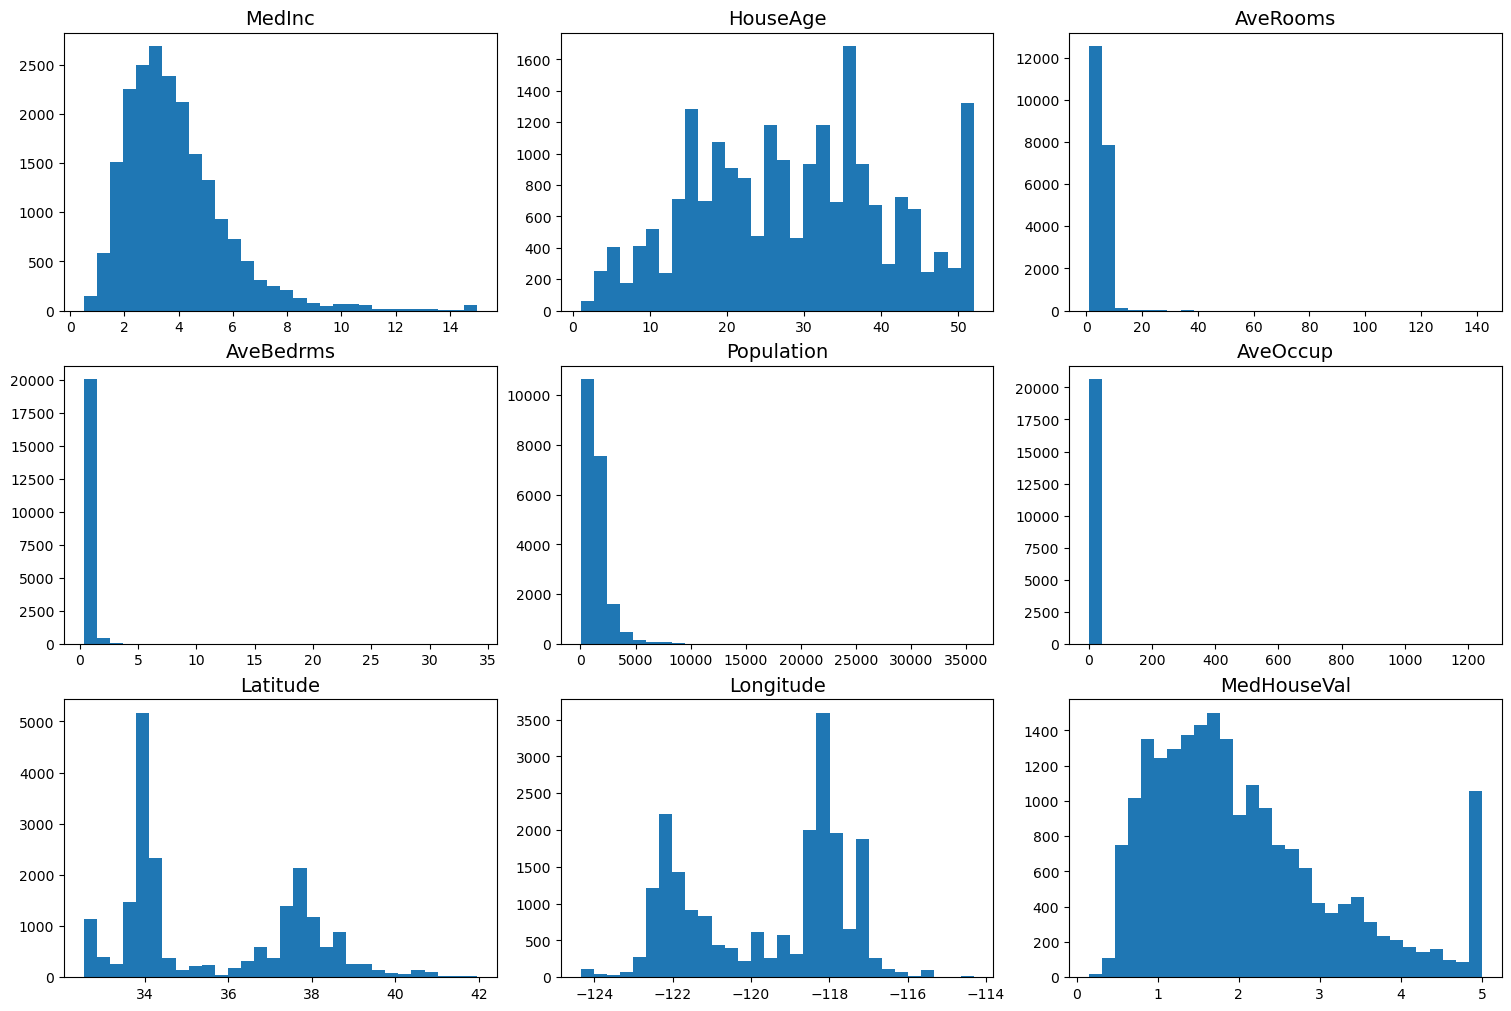

In [6]:
plot_feature_distributions(df, cfg.path, cfg.dpi, cfg.dataset)

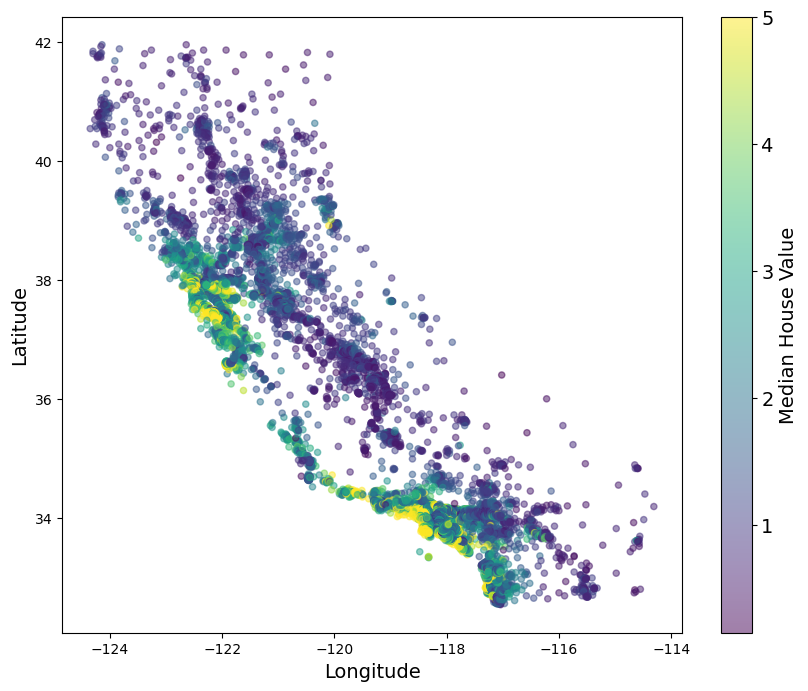

In [7]:
plot_price_by_location(df, cfg.path, cfg.dpi, cfg.dataset)

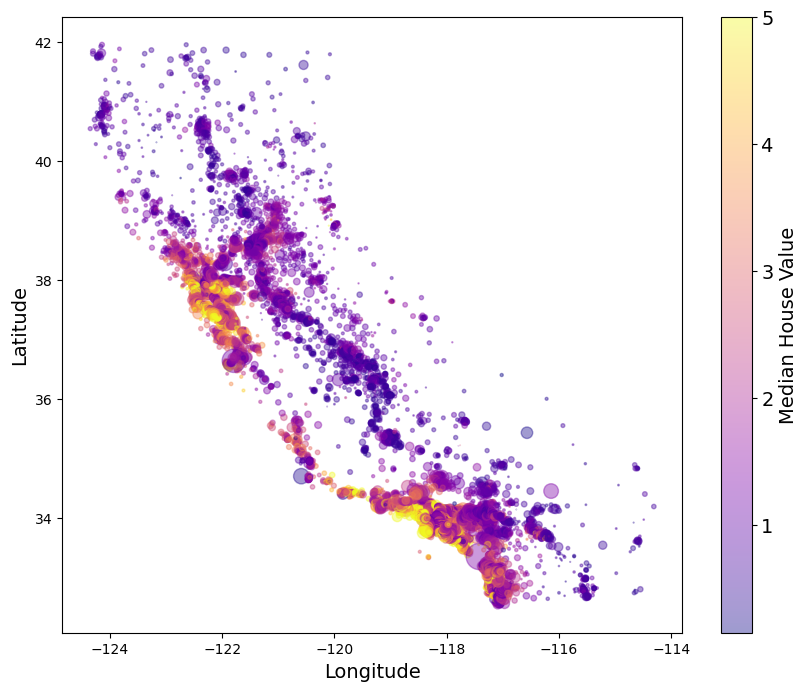

In [8]:
plot_population_and_prices(df, cfg.path, cfg.dpi, cfg.dataset)

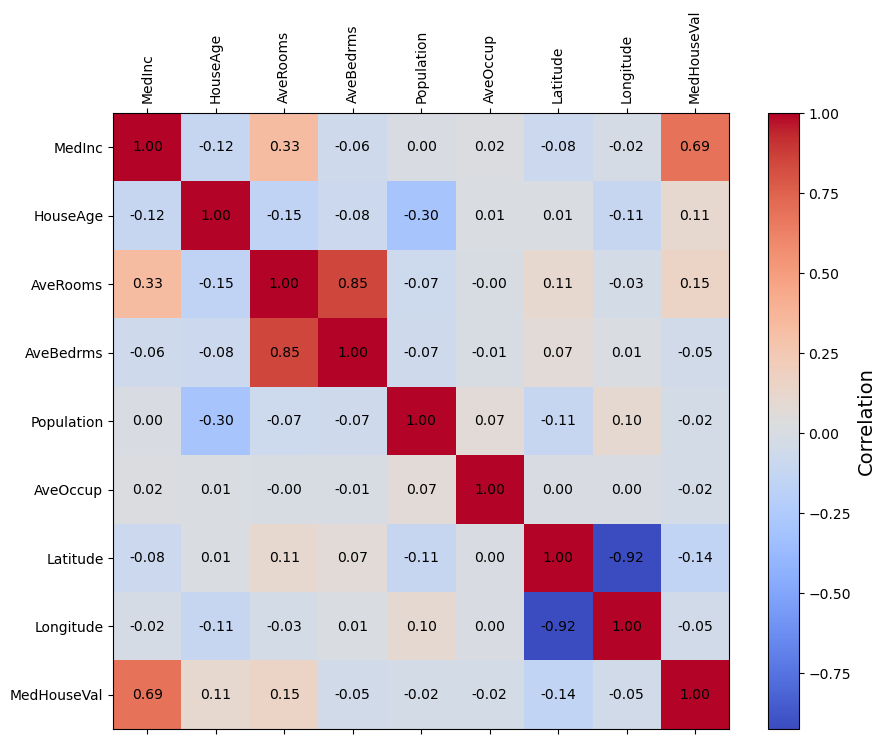

In [9]:
plot_correlation_map(df, cfg.path, cfg.dpi, cfg.dataset)

## Training

Epoch 1:
Train - MSE: 4.4835, R2-score: -2.3816
Validation - MSE: 3.8168, R2-score: -1.9127

Epoch 2:
Train - MSE: 3.2766, R2-score: -1.4713
Validation - MSE: 2.6475, R2-score: -1.0204

Epoch 3:
Train - MSE: 2.2302, R2-score: -0.6821
Validation - MSE: 1.7970, R2-score: -0.3713

Epoch 4:
Train - MSE: 1.5670, R2-score: -0.1819
Validation - MSE: 1.2979, R2-score: 0.0095

Epoch 5:
Train - MSE: 1.1782, R2-score: 0.1114
Validation - MSE: 0.9899, R2-score: 0.2446

Epoch 6:
Train - MSE: 0.9451, R2-score: 0.2871
Validation - MSE: 0.8079, R2-score: 0.3835

Epoch 7:
Train - MSE: 0.8080, R2-score: 0.3906
Validation - MSE: 0.7016, R2-score: 0.4646

Epoch 8:
Train - MSE: 0.7267, R2-score: 0.4519
Validation - MSE: 0.6345, R2-score: 0.5158

Epoch 9:
Train - MSE: 0.6710, R2-score: 0.4939
Validation - MSE: 0.5899, R2-score: 0.5499

Epoch 10:
Train - MSE: 0.6301, R2-score: 0.5248
Validation - MSE: 0.5570, R2-score: 0.5750

Epoch 11:
Train - MSE: 0.5969, R2-score: 0.5498
Validation - MSE: 0.5321, R2-score

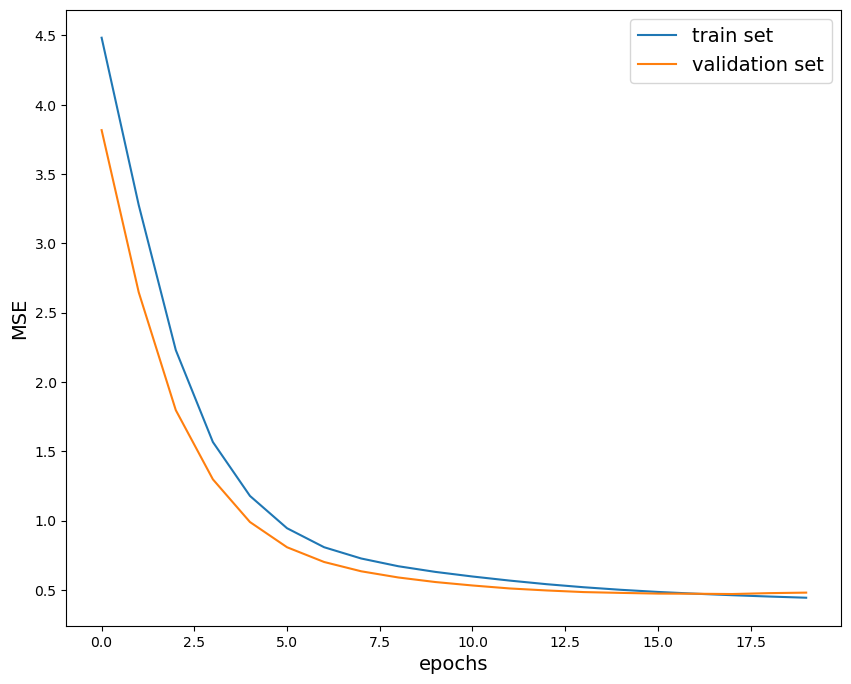

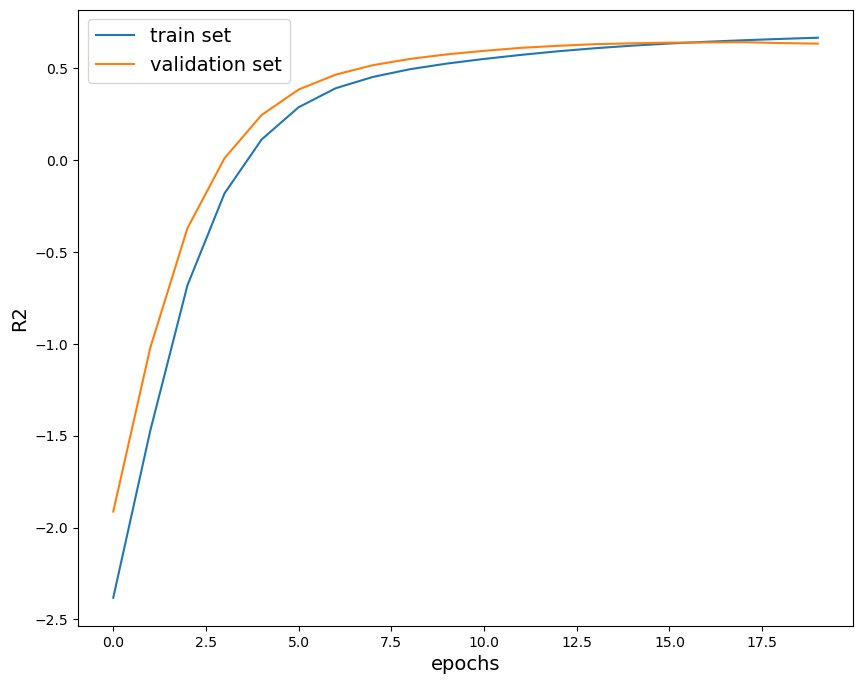

Test - MSE: 0.4950, R2-score: 0.6413


In [10]:
train, val, test = get_dataloaders(cfg.dataset, cfg.normalize, cfg.data_split, cfg.batch_size, cfg.seed)
model_pipeline(train, val, test, prms, cfg, device, plot=True)

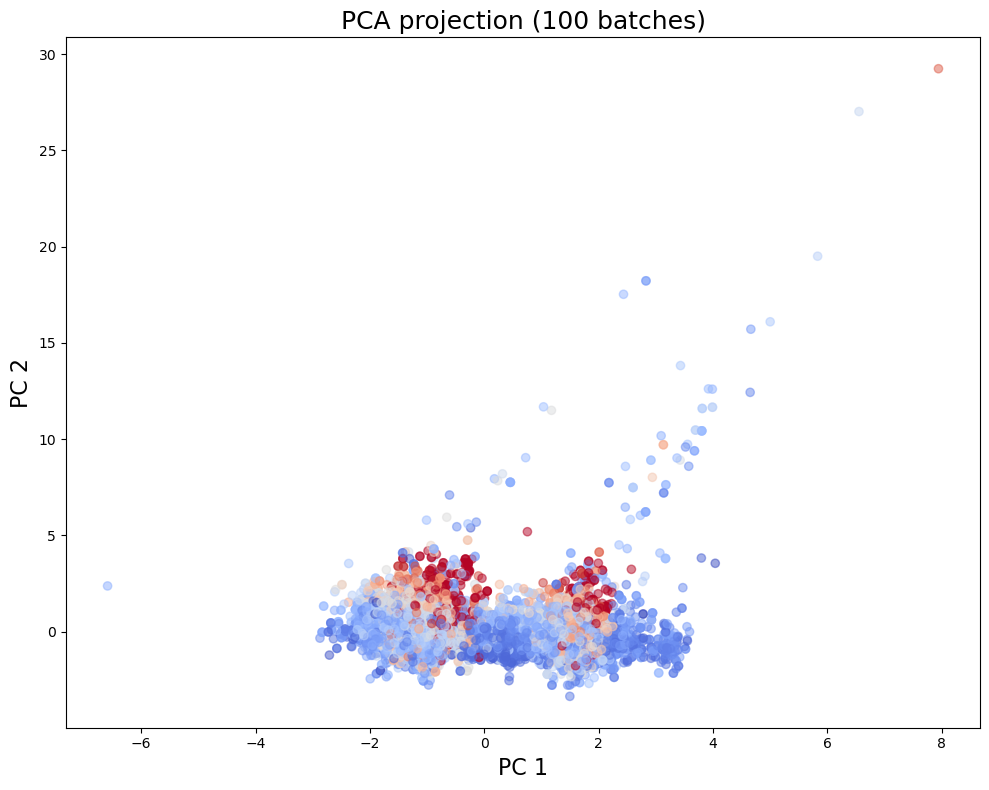

In [11]:
plot_pca(train, cfg.path, cfg.dpi, cfg.dataset, n_components=2)

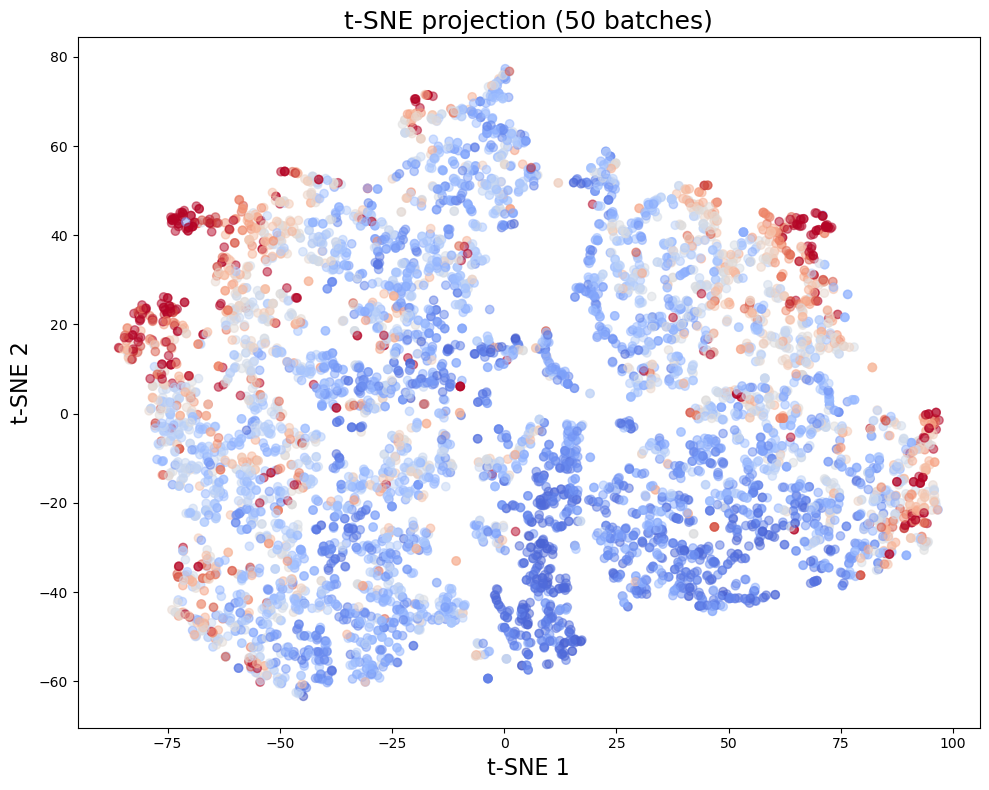

In [12]:
plot_t_sne(train, cfg.path, cfg.dpi, cfg.dataset, n_components=2, iter_size=50)